In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings
from importlib import reload
import random
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas
import PIL.Image as Image
# disable PIL.DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm
warnings.simplefilter('ignore', UndefinedMetricWarning)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

%load_ext memory_profiler

cuda


In `experiments.ipynb`, we found that:
- A buffer size of 45 was strongly preferred to a buffer size of 30.
- Layers between roughly z=8 and z=32 seemed to have the most information. The best `(Z_START, Z_DIM)` values were (16, 16), (8, 32), (8, 16), and (0, 32).
- In terms of optimizer-scheduler combos, any of SGD with OneCycleLR or SGD with CyclicLR with a max learning rate around 3e-2, or Adam with a learning rate around 5e-3, is possible. However, in the SGD strategies, spending a long time around learning rate 3e-2 risked causing the model's weights to blow up. Thus, for longer training periods, it seems advisable to combine the cyclic schedule with a slow decay, and to keep the up-ramp of the OneCycle schedule short, either by a small value for `pct_start` in the scheduler, or by chaining it with learning at a slow, constant learning rate.
- We came to no conclusion on batch sizes -- I'll stick to 32.

Today I'd like to test the capabilities of this model in more difficult situations. There are a few tests we could do:
- Use the same workflow as in `experiments.ipynb`, but on a larger dataset. That is, we assemble a dataset from rectangles inside the fragments, and randomly split each rectangle into a training and test set.
- Train a model on pieces of one fragment, and test on non-overlapping pieces of the same fragment.
- Train a model on pieces of all three fragments, and test on non-overlapping pieces of the three fragments.
- Train a model on one or two of the fragments and test on the third.

As we perform these tests, we also want to consider the ideas mentioned before (copied from `experiments.ipynb`):
- **Optimizer parameters:** If one optimizer setup is clearly better, we can then think about tweaking optimizer parameter such as momentum. I'd prefer to wait on this until I've seen how the optimizers perform at base.
- **Data augmentation:** With or without random reflections in the cardinal directions. This is less pressing because it's a strategy for preventing overfitting, which we don't yet have a problem with.
- **Regularization:** The first things that come to mind are weight decay and early stopping. Again, these are strategies for preventing overfitting.
- **Denoising the data:** By using the updated masks provided by Brett Olsen. I am skipping this because it would affect the dataset in a positionally-dependent way, and I'm just working with a small piece of the full dataset. To experiment with this, we should focus on pieces of the dataset around the places that differ between the two masks.
- **Multi-fragment training strategies:** Some way to deal with the observation that fragment 2 is very different than fragments 1 and 3 -- do we train longer on fragment 2? Do we ignore fragment 2 at first and see if we can attain generalization from fragment 1 to 3? Do we do some kind of normalization? I'm skipping this because I don't yet know how to experiment with it rigorously.


Loading fragment from data/train/1:   0%|          | 0/24 [00:00<?, ?it/s]

Loading fragment from data/train/2:   0%|          | 0/24 [00:00<?, ?it/s]

Loading fragment from data/train/3:   0%|          | 0/24 [00:00<?, ?it/s]

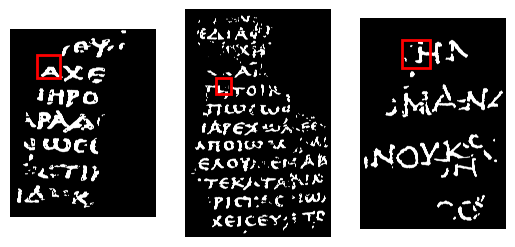

In [12]:
from utils.data_preparation import get_rect_dset_small, show_labels_with_rects

rects = [(1150, 1150, 1000, 1000), (2000, 4500, 1000, 1000), (1500, 800, 1000, 1000)]
Z_START = 8
Z_DIM = 24
BUFFER = 45
BATCH_SIZE = 32
dsets = []

dsets = [
    get_rect_dset_small(f"data/train/{i+1}", z_start=Z_START, z_dim=Z_DIM,
                        buffer=BUFFER, rect=rects[i])
    for i in range(3)
]

all_dset = data.ConcatDataset(dsets)
             

show_labels_with_rects([1, 2, 3], "data", rects)

In [13]:
# This is a lot faster than sklearn.train_test_split because the data doesn't get shuffled!
generator = torch.Generator()
generator.manual_seed(4)
%time train_dset, val_dset = data.random_split(all_dset, [0.8, 0.2], generator=generator)
print(f"{len(train_dset)} training items, {len(val_dset)} validation items.")

CPU times: user 387 ms, sys: 47.6 ms, total: 434 ms
Wall time: 229 ms
5488123 training items, 1372030 validation items.


In [14]:
BATCH_SIZE = 32
# By using replacement=True, we save some time, using torch.randint() instead of torch.randperm()
train_sampler = data.RandomSampler(data_source=train_dset, replacement=True)
val_sampler = data.RandomSampler(data_source=val_dset, replacement=True) 
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, sampler=val_sampler)
print(f"{len(train_loader)} training batches, {len(val_loader)} validation batches of batch size {BATCH_SIZE}")

171504 training batches, 42876 validation batches of batch size 32


In [1]:
# Not shuffling saves time -- the same code with shuffle=True runs 3-6x slower
from utils import Trainer, InkDetector
model = InkDetector().to(DEVICE)
LEARNING_RATE = 0.02
TRAINING_EPOCHS = 100000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
test_trainer = Trainer(model, train_loader, val_loader,
                  optimizer=optimizer,
                  criterion=criterion,
                  lr=LEARNING_RATE,
                  scheduler=scheduler,
                  scheduler_total_steps=TRAINING_EPOCHS,
                  scheduler_max_lr=LEARNING_RATE,)
test_trainer.time_train_step()
test_trainer.time_val_step()


NameError: name 'DEVICE' is not defined

In [81]:
import utils.training
reload(utils.training)
from utils.training import Trainer
from utils import InkDetector

BATCH_SIZE = 32
LEARNING_RATE = 0.02

model = InkDetector().to(DEVICE)
MODEL_NAME = "InkDetector_200k_batches_100k_epochs"
TRAINING_EPOCHS = 100000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
trainer = Trainer(model, train_loader, val_loader,
                  optimizer=optimizer,
                  criterion=criterion,
                  lr=LEARNING_RATE,
                  scheduler=scheduler,
                  scheduler_total_steps=TRAINING_EPOCHS,
                  scheduler_max_lr=LEARNING_RATE,
                  scheduler_pct_start=0.1,
                  model_name=MODEL_NAME,
                  writer="auto",
                 )

trainer.train_eval_loop(epochs=TRAINING_EPOCHS, val_epochs=VALIDATION_EPOCHS, val_period=500)

Created SummaryWriter saving to logs/2023-06-09/InkDetector_200k_batches_100k_epochs.


Training:   0%|          | 0/200000 [00:00<?, ?it/s]

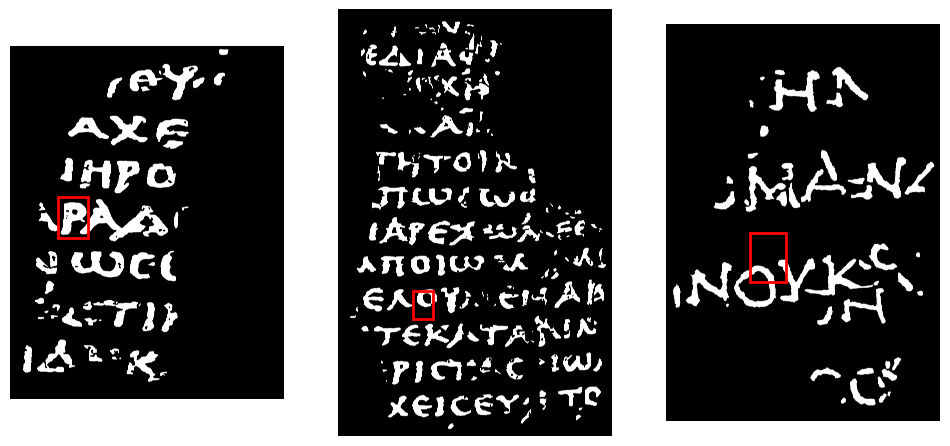

In [2]:
# Now I'm going to train on the whole dataset and see what happens.
from utils import show_labels_with_rects

VALIDATION_RECTS = [(1100, 3500, 700, 950),  # validation patch to remove from each training fragment
                    (2600, 9800, 700, 950),
                    (1600, 4000, 700, 950)]
plt.figure(figsize=(12, 6))
show_labels_with_rects([1, 2, 3], 'data/', VALIDATION_RECTS)

In [ ]:
p

In [4]:
from utils import get_train_and_val_dsets
Z_START = 8
Z_DIM = 24
BUFFER = 45
BATCH_SIZE = 32
train_dset, val_dset = get_train_and_val_dsets(
    fragments_to_use=[1,2,3],
    data_path='data/',
    z_start=Z_START,
    z_dim=Z_DIM,
    buffer=BUFFER,
    validation_rects=VALIDATION_RECTS,
    shuffle=True,
)
print("Num items (pixels) for training set:", len(train_dset))
print("Num items (pixels) for validation set:", len(val_dset))
print("Shape of subvolumes:", train_dset[0][0].shape) # channels, z, y, x

Loading fragment 1:   0%|          | 0/24 [00:00<?, ?it/s]

Loading fragment 2:   0%|          | 0/24 [00:00<?, ?it/s]

Loading fragment 3:   0%|          | 0/24 [00:00<?, ?it/s]

Num items (pixels) for training set: 150132337
Num items (pixels) for validation set: 1999953
Shape of subvolumes: torch.Size([1, 24, 91, 91])


In [5]:
train_sampler = data.RandomSampler(data_source=train_dset, replacement=True)
val_sampler = data.RandomSampler(data_source=val_dset, replacement=True) 
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, sampler=val_sampler)
print(f"{len(train_loader)} training batches, {len(val_loader)} validation batches of batch size {BATCH_SIZE}")

4691636 training batches, 62499 validation batches of batch size 32


In [8]:
from utils import Trainer, InkDetector
model = InkDetector().to(DEVICE)
MODEL_NAME = "InkDetector_full_dataset"
TRAINING_EPOCHS = 100000 
VALIDATION_EPOCHS = 500
LEARNING_RATE = 0.02
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
trainer = Trainer(model, train_loader, val_loader,
                  optimizer=optimizer,
                  criterion=criterion,
                  lr=LEARNING_RATE,
                  scheduler=scheduler,
                  scheduler_total_steps=TRAINING_EPOCHS,
                  scheduler_max_lr=LEARNING_RATE,
                  scheduler_pct_start=0.1,
                  model_name=MODEL_NAME,
                  writer="auto",
                 )

trainer.train_eval_loop(epochs=TRAINING_EPOCHS, val_epochs=VALIDATION_EPOCHS, val_period=500, save_period=10000)

Created SummaryWriter saving to logs/2023-06-09/InkDetector_full_dataset.


Training:   0%|          | 0/200000 [00:00<?, ?it/s]

Saved a checkpoint at trained_models/InkDetector_full_dataset_10000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_20000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_30000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_40000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_50000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_60000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_70000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_80000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_90000_epochs.pt.
Saved a checkpoint at trained_models/InkDetector_full_dataset_100000_epochs.pt.


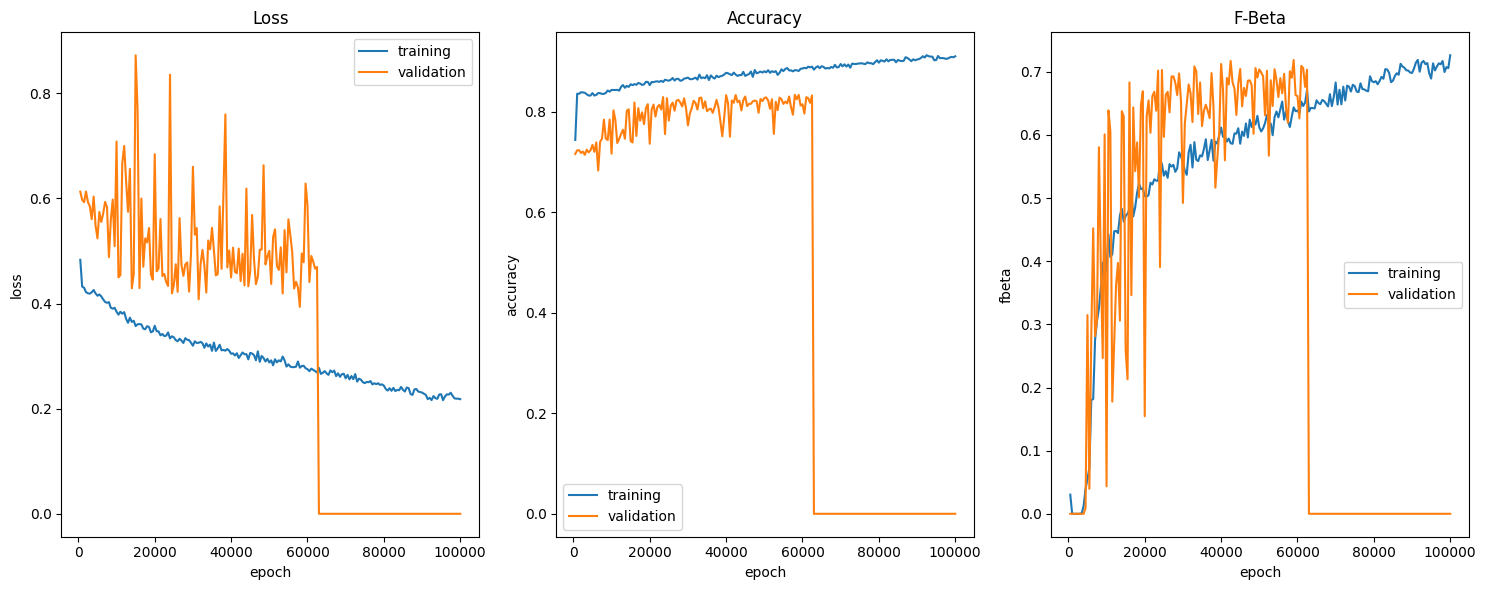

In [11]:
# Note that the validation metrics die only because we visited the whole validation dataset.
plt.figure(figsize=(15, 6))
trainer.plot_metrics()

In [3]:
from utils.models import InkDetector
model = InkDetector().to(DEVICE)
model.load_state_dict(torch.load("trained_models/InkDetector_full_dataset_100000_epochs.pt"))

<All keys matched successfully>

In [28]:
import utils.model_evaluation
reload(utils.model_evaluation)
import utils.logging
reload(utils.logging)
from utils.model_evaluation import predict_validation_rects
from utils.logging import create_writer
Z_START = 8
Z_DIM = 24
BUFFER = 45
BATCH_SIZE = 32
VALIDATION_RECTS = [(1100, 3500, 700, 950),
                    (2600, 9800, 700, 950),
                    (1600, 4000, 700, 950)]
fragments_to_use = [f'data/train/{i}' for i in range(1, 4)]
writer = create_writer(model_name="InkDetector_full_dataset")
fig, acc, loss, fbeta = predict_validation_rects(
    model, fragments_to_use=fragments_to_use, z_start=Z_START,
    z_dim=Z_DIM, buffer=BUFFER, validation_rects=VALIDATION_RECTS, 
    writer=writer
)
print(acc, loss, fbeta)
fig.show()

Created SummaryWriter saving to logs/2023-06-09/InkDetector_full_dataset.


Loading fragment from data/train/1:   0%|          | 0/24 [00:00<?, ?it/s]

Predicting on fragment data/train/1:   0%|          | 0/59210 [00:00<?, ?it/s]

Loading fragment from data/train/2:   0%|          | 0/24 [00:00<?, ?it/s]

Predicting on fragment data/train/2:   0%|          | 0/232572 [00:00<?, ?it/s]

Loading fragment from data/train/3:   0%|          | 0/24 [00:00<?, ?it/s]

Predicting on fragment data/train/3:   0%|          | 0/90619 [00:00<?, ?it/s]

0.7122908122436727 5.349772122843995 0.17012484186913845


AttributeError: Figure.show works only for figures managed by pyplot, normally created by pyplot.figure()

In [16]:
criterion = nn.BCEWithLogitsLoss()
model.eval()
subvolumes, inklabels = next(iter(val_loader))
with torch.inference_mode():
    outputs = model(subvolumes.to(DEVICE))
print(criterion(inklabels.to(DEVICE), outputs))

tensor(0.6448, device='cuda:0')


In [ ]:
# There's still a memory leak...
self.model.train()
for i, (subvolumes, inklabels) in enumerate(cycle(self.train_loader)):
    pbar.update()
    if i >= epochs:
        break
    outputs, loss = self.train_step(subvolumes, inklabels)
    # Updates the training_loss, training_fbeta and training_accuracy
    train_metrics.update(outputs, inklabels, loss)
    if (i + 1) % val_period == 0 or i+1 == len(self.train_loader):
        # record number of epochs and training metrics
        self.histories['epochs'].append(i+1)
        self.histories['train_loss'].append(train_metrics.loss / val_period)
        self.histories['train_acc'].append(train_metrics.accuracy / val_period)
        self.histories['train_fbeta'].append(train_metrics.fbeta / val_period)
        train_metrics.reset()

        # record learning rate
        if self.scheduler_class is not None:
            self.histories['lr'].append(self.scheduler.get_last_lr()[0])
        else:
            self.histories['lr'].append(self.optimizer.param_groups[0]['lr'])

        # predict on validation data and record metrics
        self.model.eval()
        for j, (val_subvolumes, val_inklabels) in enumerate(val_iterator):
            pbar.update()
            if j >= val_epochs:
                break
            val_outputs, val_loss = self.val_step(val_subvolumes, val_inklabels)
            val_metrics.update(val_outputs, val_inklabels, val_loss)
        self.model.train()

        self.histories['val_loss'].append(val_metrics.loss / j)
        self.histories['val_acc'].append(val_metrics.accuracy / j)
        self.histories['val_fbeta'].append(val_metrics.fbeta / j)
        val_metrics.reset()

        # If logging to TensorBoard, add metrics to writer
        if self.writer is not None:
            self.writer.add_scalars(
                main_tag="Loss",
                tag_scalar_dict={
                    "train_loss": self.histories['train_loss'][-1], 
                    "val_loss": self.histories['val_loss'][-1], 
                }, 
                global_step=i+1)
            self.writer.add_scalars(
                main_tag="Accuracy",  
                tag_scalar_dict={  
                    "train_acc": self.histories['train_acc'][-1], 
                    "val_acc": self.histories['val_acc'][-1], 
                }, 
                global_step=i+1)
            self.writer.add_scalars(
                main_tag="Fbeta@0.5", 
                tag_scalar_dict={ 
                    "train_fbeta": self.histories['train_fbeta'][-1], 
                    "val_fbeta": self.histories['val_fbeta'][-1], 
                }, 
                global_step=i+1)
            self.writer.add_scalar(
                "Learning rate",
                self.histories['lr'][-1], 
                global_step=i+1)
            # write to disk
            self.writer.flush()

        # If loss is NaN, the model died and we might as well stop training.
        if np.isnan(self.histories['val_loss'][-1]) or np.isnan(self.histories['train_loss'][-1]):
            print (f"Model died at training epoch {i+1}, stopping training.")
            break

    # Optionally save a copy of the model
    if save_period is not None and (i + 1) % save_period == 0:
        self.save_checkpoint(f"{i+1}_epochs")